In [ ]:
import sys
sys.path.insert(0, '..')

from ComputeC import computeC
from Process_gene_data import process_gene_data
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from matplotlib.ticker import FixedLocator

Data one

In [2]:
# 1
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/example_1.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24], [1, 2, 3, 4, 5, 6], [4, 5, 8, 9, 10, 11], [9, 10, 12, 13, 14, 15], [22, 23, 25, 26]]
{1: 919, 2: 184, 3: 179, 4: 176, 5: 106, 6: 945, 7: 82, 8: 91, 9: 107, 10: 90, 11: 81, 12: 157, 13: 107, 14: 103, 15: 85, 16: 135, 17: 96, 18: 138, 19: 117, 20: 166, 21: 386, 22: 180, 23: 79, 24: 216, 25: 216, 26: 95}


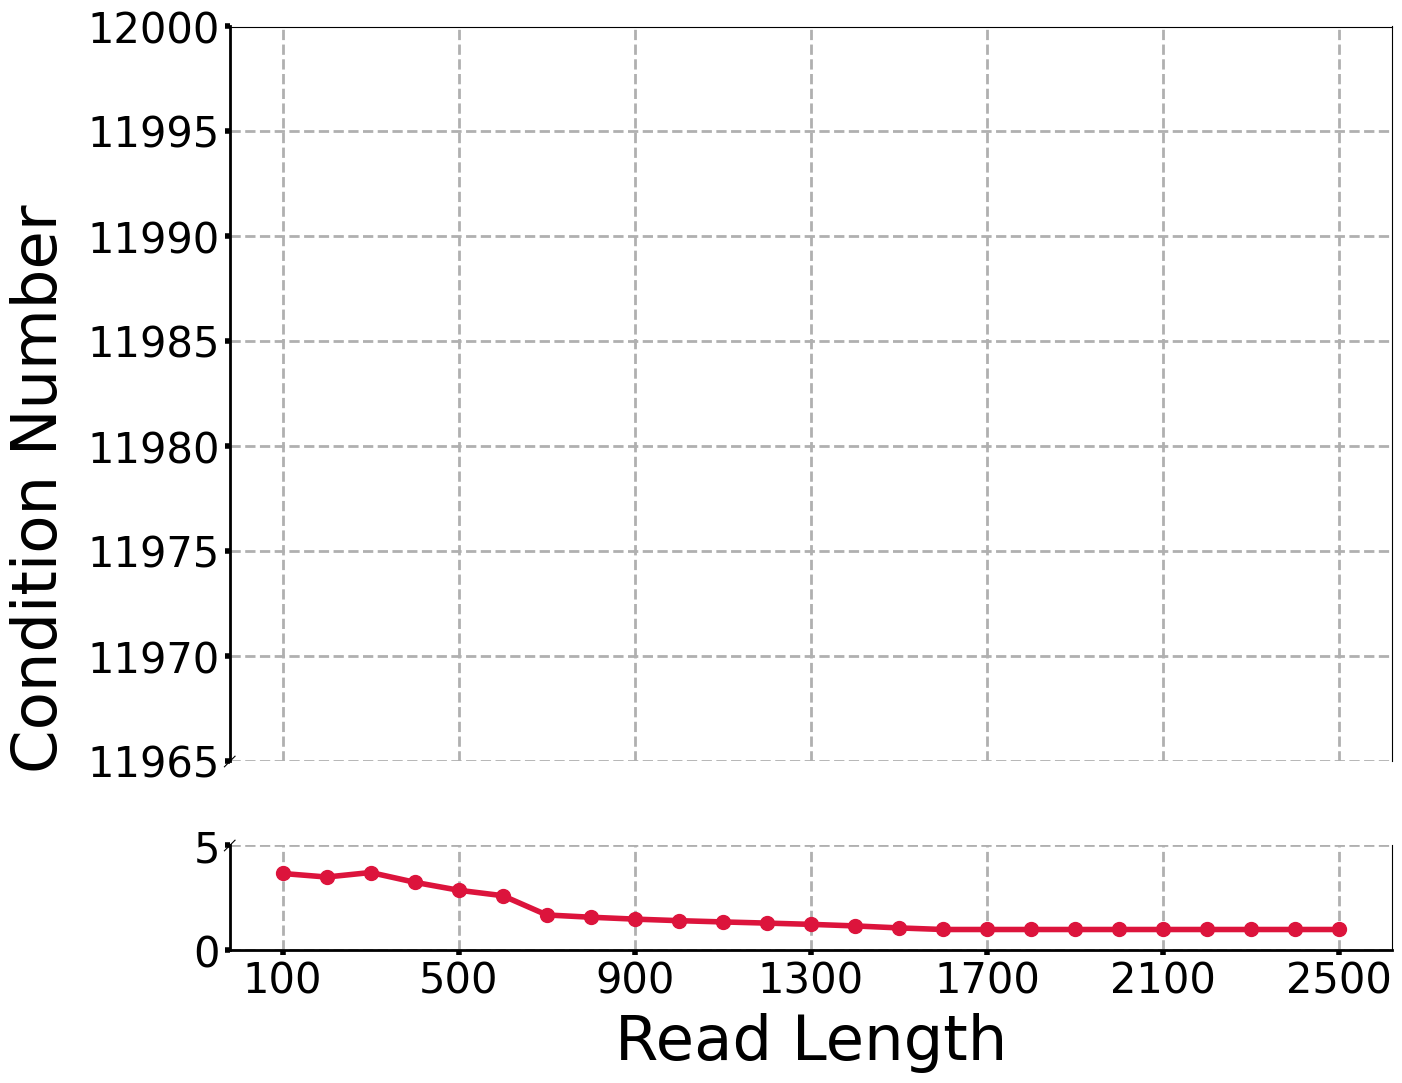

In [ ]:
# Calculate condition number
sums = [sum(gene_dict[key] for key in sublist) for sublist in arrays]

# Find the sublist with maximum sum
max_sum = max(sums)
max_readlengh = max_sum

maxc = []
k = 0
# Generate readlengh range
readlengh_range = np.linspace(100, 2501, 25, endpoint=True, dtype=int)

for readlengh in readlengh_range:
    C = computeC(arrays, readlengh, gene_dict)
    eigenvalues, eigenvectors = np.linalg.eig(C.T @ C)
    max_element = max(eigenvalues)/min(eigenvalues)
    maxc.append(max_element)

readlengh_range = np.arange(100, 2501, 100)

# Create main plot
fig = plt.figure(figsize=(15, 12))

# Use brokenaxes to create plot with truncated y-axis
bax = brokenaxes(ylims=((0, 5), (11965, 12000)), hspace=.2, d=0.005)  # Adjust ylims and hspace to fit your data

# Plot data
line1 = bax.plot(readlengh_range, maxc, 'o-', markersize=10, color='crimson', label='Condition Number', linewidth=4)

# Set axis labels
bax.set_xlabel('Read Length', fontsize=45, labelpad=45)
bax.set_ylabel('Condition Number', fontsize=45, labelpad=115)

# Create proxy artist
from matplotlib.lines import Line2D
proxy = [Line2D([0], [0], color='crimson', marker='o', linestyle='-', markersize=5)]

# Merge legend
# bax.legend(proxy, ['Condition Number'], loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fontsize=14)  # Set legend font size

# Add grid lines
bax.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)

grid_positions = [100, 500, 900, 1300, 1700, 2100, 2500]  # Set vertical grid line positions
for ax in bax.axs:
    ax.xaxis.set_major_locator(FixedLocator(grid_positions))  # Set exact positions for vertical grid lines
    ax.grid(True, which='major', axis='x', linestyle='--', alpha=1.0, linewidth=2.0)
    
# Add right and top borders
for ax in bax.axs:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
    ax.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')

# Only add horizontal lines on top and right
bax.axs[1].spines['top'].set_visible(False)  # Hide bottom border

# Show plot
plt.show()

In [ ]:
# Simulate sampling process

np.random.seed(0)  # Set fixed seed
w = np.random.dirichlet(np.ones(len(arrays)), size=1)[0]
np.random.seed(None)  # Cancel fixed seed, restore randomness

# Set number of samples
n = 800

readlengh_range = np.arange(100, 2501, 100)

# Set number of repetitions
times = 100

number_total = []
for readlengh in readlengh_range:
    # print(readlengh)
    number_r = []
    length = []
    for array in arrays:
        length_array = sum([gene_dict[key] for key in array])
        length.append(length_array)
        
    if any(l <= readlengh for l in length):
        indices_to_remove = [i for i, l in enumerate(length) if l <= readlengh]
        w_new = np.delete(w, indices_to_remove)
        w_new = w_new / np.sum(w_new)  # Redistribute proportions
    else:
        w_new = w
    
    C = computeC(arrays, readlengh, gene_dict)
    
    for i in range(times):

        # Calculate exact P
        P = C@w_new.T

        Delta_P = []
        # Calculate fluctuation values based on sampling number n and values in p
        def generate_normal_distribution(value, n):
            variance = value * (1 - value) / n
            std_deviation = np.sqrt(variance)
            return np.random.normal(0, std_deviation)

        for value in P:
            Delta_P.append(generate_normal_distribution(value, n))
            
        # print(Delta_P)
        Delta_P_norm = np.array(Delta_P)
        #Delta_P_norm1 = Delta_P_norm[0]
        # Calculate normalized P_hat
        P_hat = (P+Delta_P_norm)/np.sum(P+Delta_P_norm)

        Delta_P = P_hat - P

        # Inverse solve for true w
        w_hat = np.linalg.inv(C.T@C)@C.T@(P_hat)
        Delta_w = np.linalg.norm(w_hat - w_new, ord=2)
        
        number_r.append(Delta_w)
    number_total.append(number_r)

In [ ]:
data = number_total

# Configure matplotlib for Chinese font support on macOS
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'STHeiti', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # Correctly display minus sign

# Generate colors using plt.cm.jet colormap from light to dark
box_colors = [plt.cm.YlGnBu(i / len(data)) for i in range(len(data))]
box_colors.reverse()

# Create box plot
fig, ax = plt.subplots(figsize=(15,12), dpi = 600)

# Use boxplot function to create box plot
# patch_artist=True is used to set box colors
# notch=True is used to add notches to boxes
boxes = ax.boxplot(data, patch_artist=True, notch=False, medianprops=dict(color='none'))

# Set color for each box
for box, color in zip(boxes['boxes'], box_colors):
    box.set_facecolor(color)

# Calculate median values and draw curve
median_values = [np.median(box) for box in data]
ax.plot(range(1, len(median_values) + 1), median_values, 'ro-', markersize=4, linewidth=3)

# Set horizontal tick labels
xlable = list(range(1, len(data) + 1))
ax.set_xticks(xlable[::4])  # Show every 4th tick
xlable2 = list(range(100, 2501, 100))
xlable2 = [str(i) for i in xlable2]
ax.set_xticklabels(xlable2[::4])  # Show every 4th tick label
ax.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
ax.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')


# Add title and labels
# plt.title('Number of drawings is 800',fontsize=20)
plt.xlabel('Read Length', fontsize=45, labelpad=20)
plt.ylabel('Error', fontsize=45, labelpad=15)

# Add grid lines
ax.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)

plt.ylim(0, 0.4)
# Show plot
plt.show()

Data two

In [18]:
# 2
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/example_2.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[1, 2, 3, 4, 5, 10, 12, 13], [4, 5, 9, 10, 12, 13], [5, 8, 9, 10, 12, 13], [5, 6, 8, 9, 10, 12, 13], [11, 12, 13], [1, 2, 3, 4, 5, 7, 10, 12, 13], [1, 2, 4, 5, 10, 12, 13]]
{1: 1872, 2: 134, 3: 124, 4: 171, 5: 77, 6: 97, 7: 80, 8: 94, 9: 134, 10: 187, 11: 403, 12: 65, 13: 362}


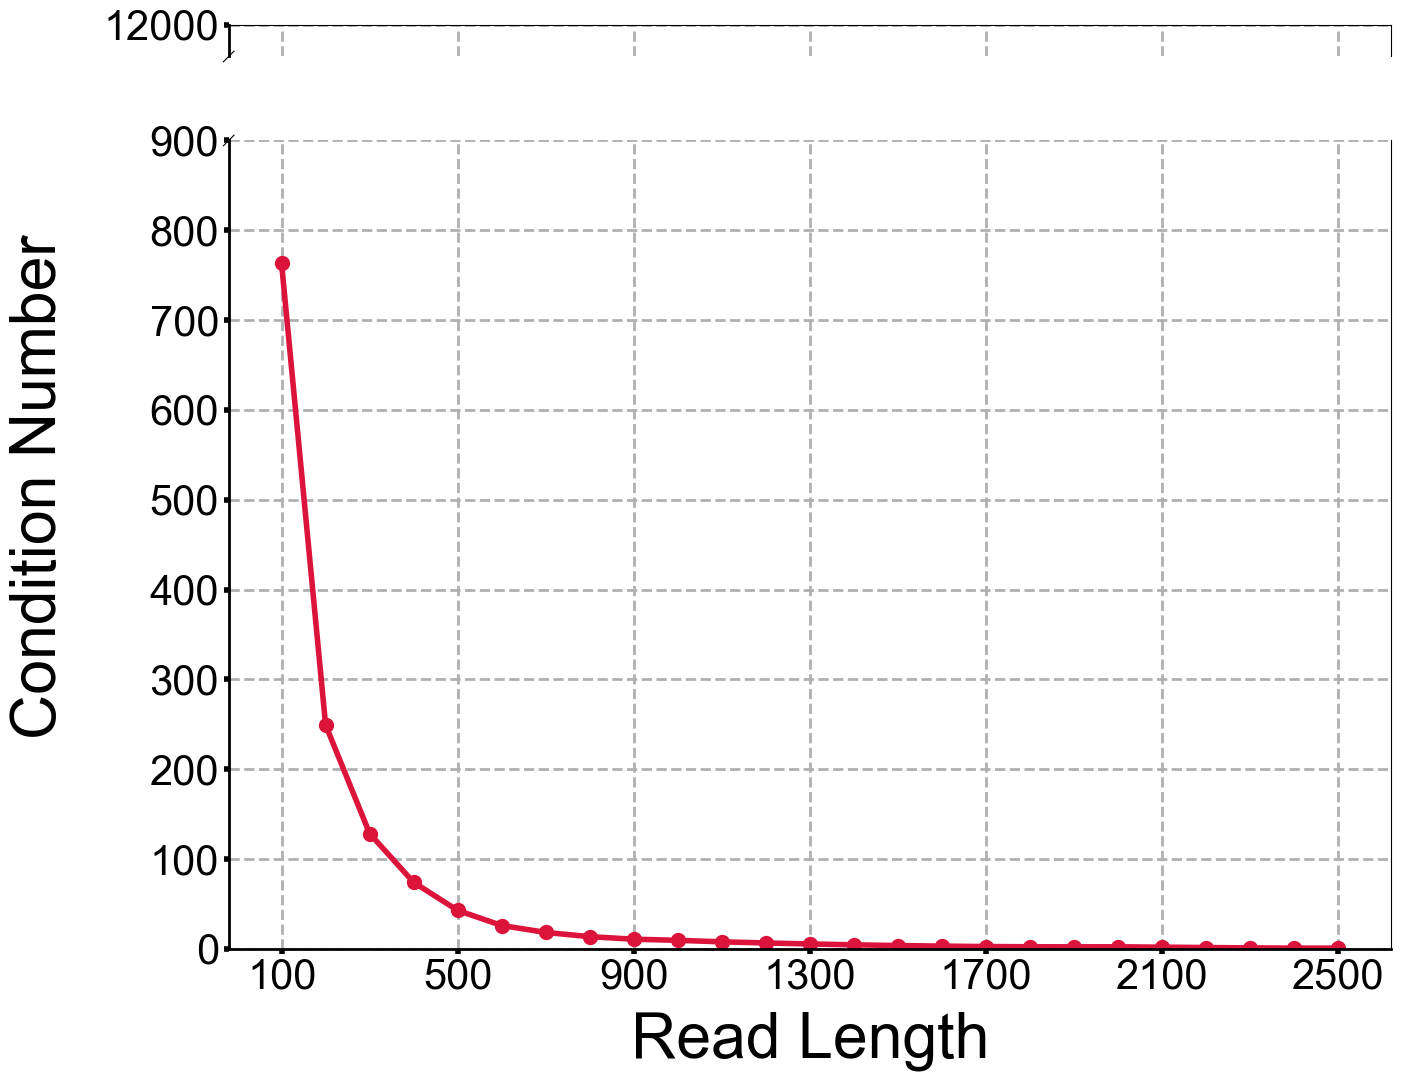

In [ ]:
# Calculate condition number
sums = [sum(gene_dict[key] for key in sublist) for sublist in arrays]

# Find the sublist with maximum sum
max_sum = max(sums)
max_readlengh = max_sum

maxc = []
k = 0
# Generate readlengh range
readlengh_range = np.linspace(100, 2501, 25, endpoint=True, dtype=int)

for readlengh in readlengh_range:
    C = computeC(arrays, readlengh, gene_dict)
    eigenvalues, eigenvectors = np.linalg.eig(C.T @ C)
    max_element = max(eigenvalues)/min(eigenvalues)
    maxc.append(max_element)

readlengh_range = np.arange(100, 2501, 100)

# Create main plot
fig = plt.figure(figsize=(15, 12))

# Use brokenaxes to create plot with truncated y-axis
bax = brokenaxes(ylims=((0, 900), (11965, 12000)), hspace=.2, d=0.005)  # Adjust ylims and hspace to fit your data

# Plot data
line1 = bax.plot(readlengh_range, maxc, 'o-', markersize=10, color='crimson', label='Condition Number', linewidth=4)

# Set axis labels
bax.set_xlabel('Read Length', fontsize=45, labelpad=45)
bax.set_ylabel('Condition Number', fontsize=45, labelpad=115)

# Create proxy artist
from matplotlib.lines import Line2D
proxy = [Line2D([0], [0], color='crimson', marker='o', linestyle='-', markersize=5)]

# Merge legend
# bax.legend(proxy, ['Condition Number'], loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fontsize=14)  # Set legend font size

# Add grid lines
bax.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)

grid_positions = [100, 500, 900, 1300, 1700, 2100, 2500]  # Set vertical grid line positions
for ax in bax.axs:
    ax.xaxis.set_major_locator(FixedLocator(grid_positions))  # Set exact positions for vertical grid lines
    ax.grid(True, which='major', axis='x', linestyle='--', alpha=1.0, linewidth=2.0)
    
# Add right and top borders
for ax in bax.axs:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
    ax.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')

# Only add horizontal lines on top and right
bax.axs[1].spines['top'].set_visible(False)  # Hide bottom border

# Show plot
plt.show()

In [ ]:
# Simulate sampling process

np.random.seed(0)  # Set fixed seed
w = np.random.dirichlet(np.ones(len(arrays)), size=1)[0]
np.random.seed(None)  # Cancel fixed seed, restore randomness

# Set number of samples
n = 800

readlengh_range = np.arange(100, 2501, 100)

# Set number of repetitions
times = 100

number_total = []
for readlengh in readlengh_range:
    # print(readlengh)
    number_r = []
    length = []
    for array in arrays:
        length_array = sum([gene_dict[key] for key in array])
        length.append(length_array)
        
    if any(l <= readlengh for l in length):
        indices_to_remove = [i for i, l in enumerate(length) if l <= readlengh]
        w_new = np.delete(w, indices_to_remove)
        w_new = w_new / np.sum(w_new)  # Redistribute proportions
    else:
        w_new = w
    
    C = computeC(arrays, readlengh, gene_dict)
    
    for i in range(times):

        # Calculate exact P
        P = C@w_new.T

        Delta_P = []
        # Calculate fluctuation values based on sampling number n and values in p
        def generate_normal_distribution(value, n):
            variance = value * (1 - value) / n
            std_deviation = np.sqrt(variance)
            return np.random.normal(0, std_deviation)

        for value in P:
            Delta_P.append(generate_normal_distribution(value, n))
            
        # print(Delta_P)
        Delta_P_norm = np.array(Delta_P)
        #Delta_P_norm1 = Delta_P_norm[0]
        # Calculate normalized P_hat
        P_hat = (P+Delta_P_norm)/np.sum(P+Delta_P_norm)

        Delta_P = P_hat - P

        # Inverse solve for true w
        w_hat = np.linalg.inv(C.T@C)@C.T@(P_hat)
        Delta_w = np.linalg.norm(w_hat - w_new, ord=2)
        
        number_r.append(Delta_w)
    number_total.append(number_r)

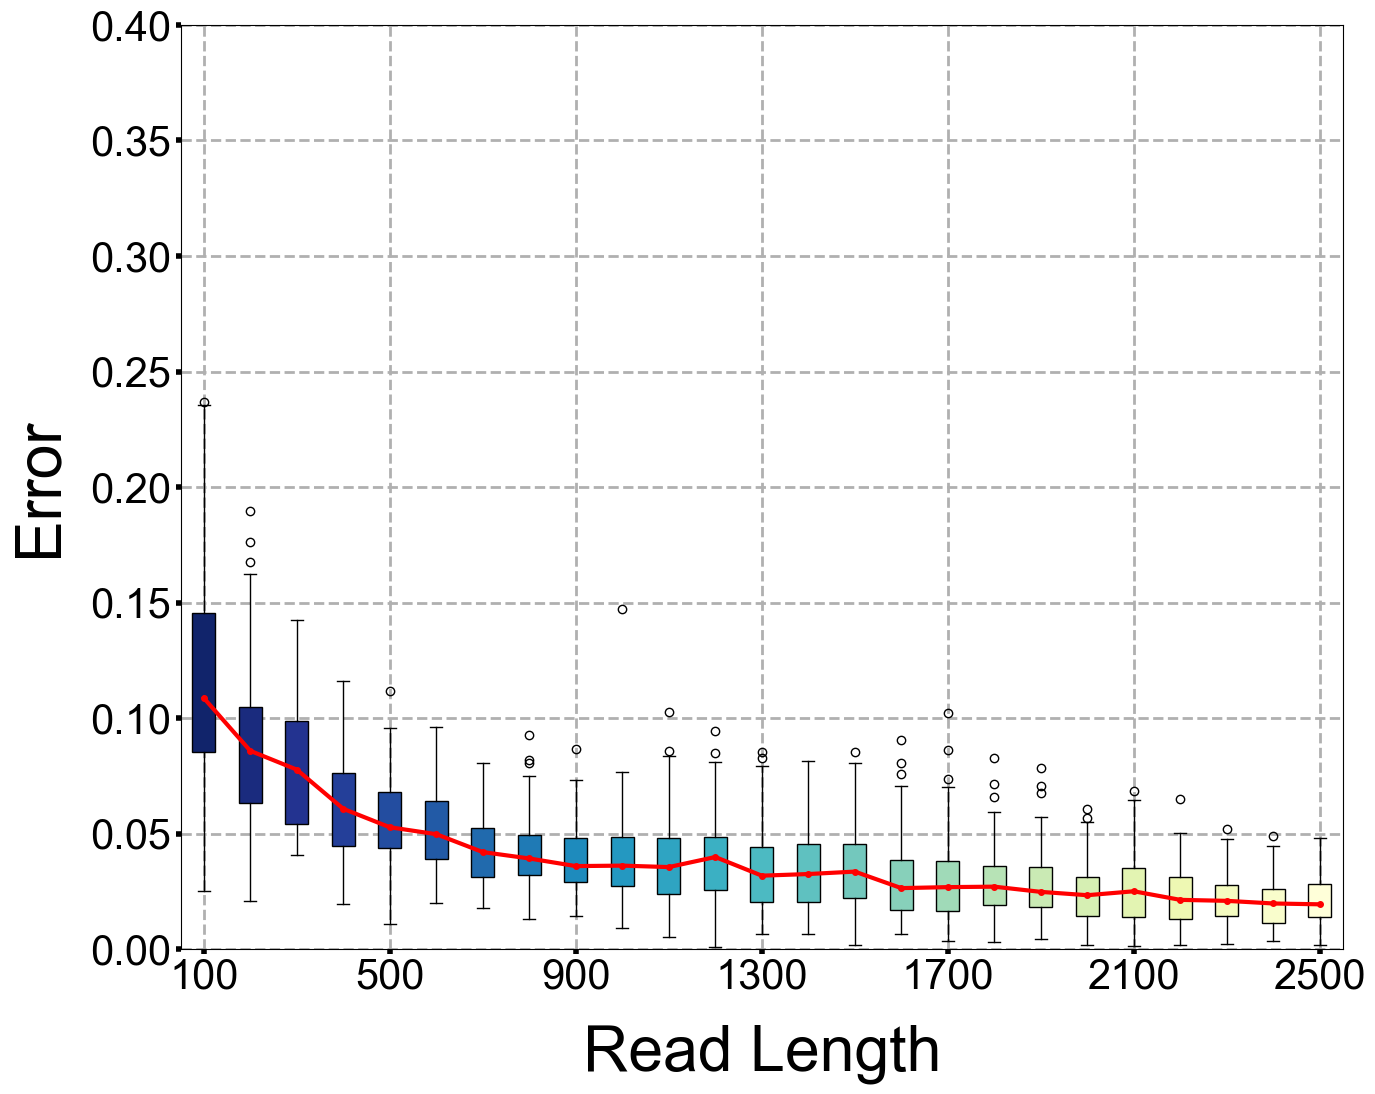

In [ ]:
data = number_total

# Configure matplotlib for Chinese font support on macOS
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'STHeiti', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # Correctly display minus sign

# Generate colors using plt.cm.jet colormap from light to dark
box_colors = [plt.cm.YlGnBu(i / len(data)) for i in range(len(data))]
box_colors.reverse()

# Create box plot
fig, ax = plt.subplots(figsize=(15,12))

# Use boxplot function to create box plot
# patch_artist=True is used to set box colors
# notch=True is used to add notches to boxes
boxes = ax.boxplot(data, patch_artist=True, notch=False, medianprops=dict(color='none'))

# Set color for each box
for box, color in zip(boxes['boxes'], box_colors):
    box.set_facecolor(color)

# Calculate median values and draw curve
median_values = [np.median(box) for box in data]
ax.plot(range(1, len(median_values) + 1), median_values, 'ro-', markersize=4, linewidth=3)

# Set horizontal tick labels
xlable = list(range(1, len(data) + 1))
ax.set_xticks(xlable[::4])  # Show every 4th tick
xlable2 = list(range(100, 2501, 100))
xlable2 = [str(i) for i in xlable2]
ax.set_xticklabels(xlable2[::4])  # Show every 4th tick label
ax.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
ax.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')


# Add title and labels
# plt.title('Number of drawings is 800',fontsize=20)
plt.xlabel('Read Length', fontsize=45, labelpad=20)
plt.ylabel('Error', fontsize=45, labelpad=15)

# Add grid lines
ax.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)

plt.ylim(0, 0.4)
# Show plot
plt.show()

Data three

In [2]:
# 3
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/example_3.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[1, 2, 3, 5, 10], [1, 2, 3, 10], [1, 2, 3, 5, 8], [1, 2, 3, 5, 7], [3, 5, 10], [3, 5, 11], [3, 5, 6], [3, 4, 5, 9]]
{1: 2559, 2: 153, 3: 462, 4: 139, 5: 56, 6: 337, 7: 29, 8: 172, 9: 161, 10: 315, 11: 210}


In [ ]:
# Calculate condition number
sums = [sum(gene_dict[key] for key in sublist) for sublist in arrays]

# Find the sublist with maximum sum
max_sum = max(sums)
max_readlengh = max_sum

maxc = []
k = 0
# Generate readlengh range
readlengh_range = np.linspace(100, 2501, 25, endpoint=True, dtype=int)

for readlengh in readlengh_range:
    C = computeC(arrays, readlengh, gene_dict)
    eigenvalues, eigenvectors = np.linalg.eig(C.T @ C)
    max_element = max(eigenvalues)/min(eigenvalues)
    maxc.append(max_element)

readlengh_range = np.arange(100, 2501, 100)

# Create main plot
fig, ax1 = plt.subplots(figsize=(15, 12), dpi = 600)

fig=plt.gcf()

readlengh_range = np.arange(100, 2501, 100)
# Plot first set of data (needs truncation handling)
line1, = ax1.plot(readlengh_range, maxc, 'o-', markersize=10,color = 'crimson', label='Condition Number', linewidth=4)
#ax1.set_ylim(0, 20)
ax1.set_xlabel('Read Length', fontsize=45, labelpad=15)
ax1.set_ylabel('Condition Number', fontsize=45, labelpad=9)

# Adjust inset window position and size
inset_ax = fig.add_axes([0.65, 0.65, 0.18, 0.18])  # [left, bottom, width, height]

# Plot high value points of first data set in inset
inset_ax.plot(readlengh_range, maxc, 'o-', color = 'crimson',markersize=10, linewidth=4)
inset_ax.set_ylim(40000, 50000)

# Hide inset x-axis information
inset_ax.set_xticks([])  # Hide x-axis ticks
inset_ax.set_xlabel('')  # Hide x-axis label

# Set y-axis range
ax1.set_ylim(0, 12000)

grid_positions = [100, 500, 900, 1300, 1700, 2100, 2500]  # Set vertical grid line positions
ax1.xaxis.set_major_locator(FixedLocator(grid_positions))  # Set exact positions for vertical grid lines
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=1.0, linewidth=2.0)

# Add grid lines
inset_ax.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)
ax1.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)

ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
ax1.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')

inset_ax.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
inset_ax.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')

# Show plot
plt.show()

In [ ]:
# Simulate sampling process

np.random.seed(0)  # Set fixed seed
w = np.random.dirichlet(np.ones(len(arrays)), size=1)[0]
np.random.seed(None)  # Cancel fixed seed, restore randomness

# Set number of samples
n = 400

np.random.seed(335)
readlengh_range = np.arange(100, 2501, 100)

# Set number of repetitions
times = 100

number_total = []
for readlengh in readlengh_range:
    # print(readlengh)
    number_r = []
    length = []
    for array in arrays:
        length_array = sum([gene_dict[key] for key in array])
        length.append(length_array)
        
    if any(l <= readlengh for l in length):
        indices_to_remove = [i for i, l in enumerate(length) if l <= readlengh]
        w_new = np.delete(w, indices_to_remove)
        w_new = w_new / np.sum(w_new)  # Redistribute proportions
    else:
        w_new = w
    
    C = computeC(arrays, readlengh, gene_dict)
    
    for i in range(times):

        # Calculate exact P
        P = C@w_new.T

        Delta_P = []
        # Calculate fluctuation values based on sampling number n and values in p
        def generate_normal_distribution(value, n):
            variance = value * (1 - value) / n
            std_deviation = np.sqrt(variance)
            return np.random.normal(0, std_deviation)

        for value in P:
            Delta_P.append(generate_normal_distribution(value, n))
            
        # print(Delta_P)
        Delta_P_norm = np.array(Delta_P)
        #Delta_P_norm1 = Delta_P_norm[0]
        # Calculate normalized P_hat
        P_hat = (P+Delta_P_norm)/np.sum(P+Delta_P_norm)

        Delta_P = P_hat - P

        # Inverse solve for true w
        w_hat = np.linalg.inv(C.T@C)@C.T@(P_hat)
        Delta_w = np.linalg.norm(w_hat - w_new, ord=2)
        
        number_r.append(Delta_w)
    number_total.append(number_r)

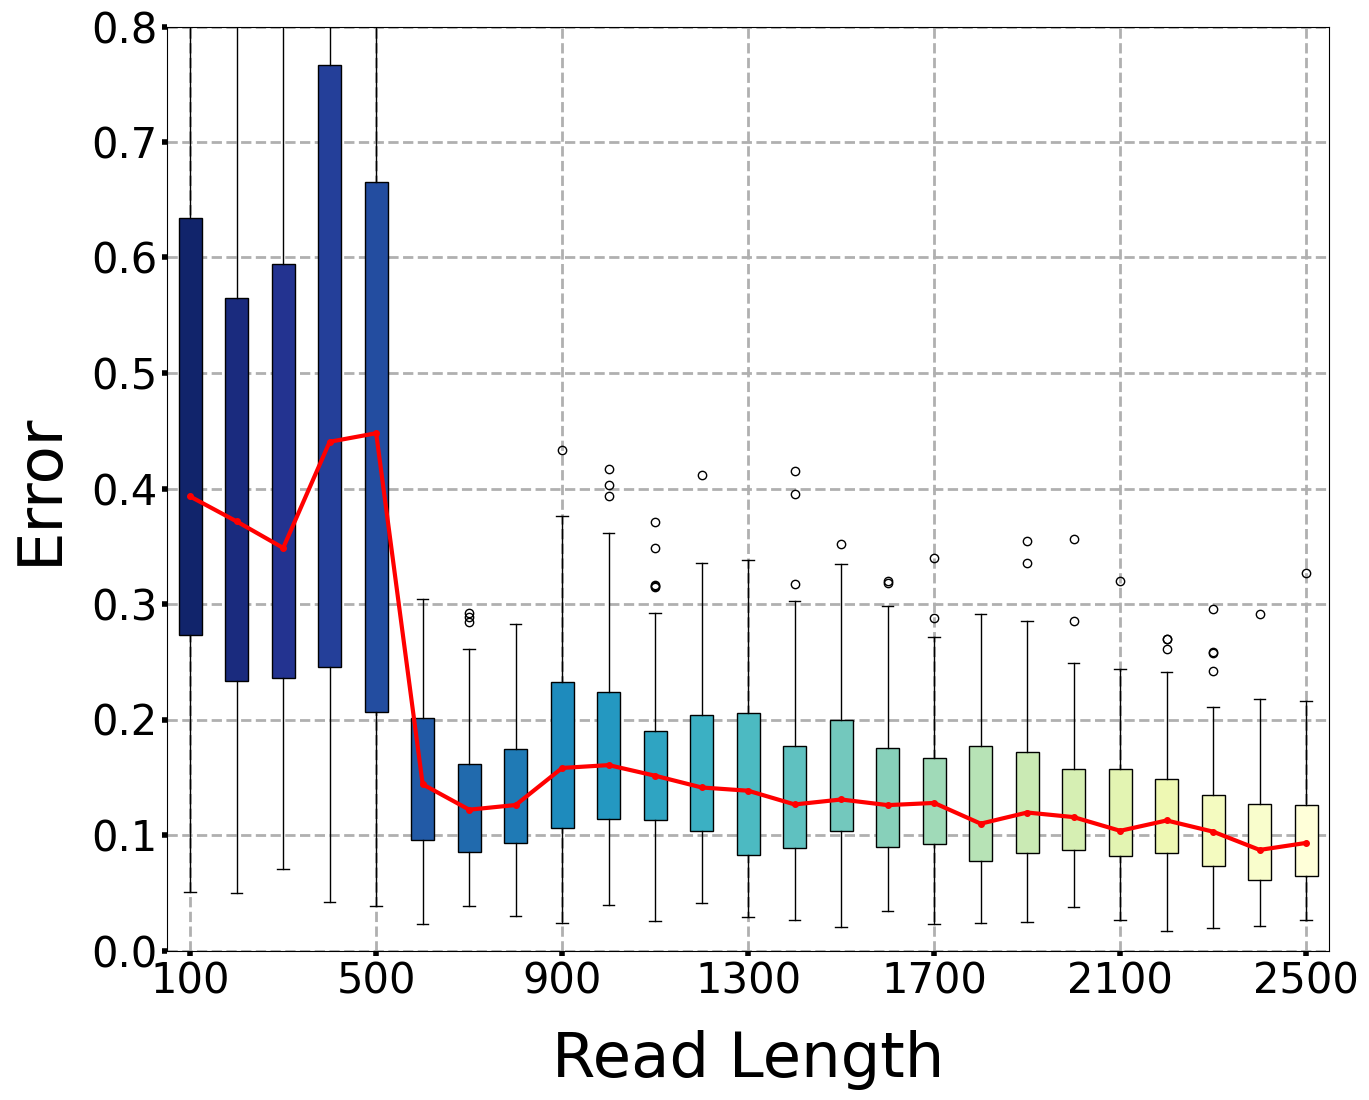

In [172]:
data = number_total

# Configure matplotlib for Chinese font support on macOS
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'STHeiti', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # Correctly display minus sign

# Generate colors using plt.cm.jet colormap from light to dark
box_colors = [plt.cm.YlGnBu(i / len(data)) for i in range(len(data))]
box_colors.reverse()

# Create box plot
fig, ax = plt.subplots(figsize=(15,12))

# Use boxplot function to create box plot
# patch_artist=True is used to set box colors
# notch=True is used to add notches to boxes
boxes = ax.boxplot(data, patch_artist=True, notch=False, medianprops=dict(color='none'))

# Set color for each box
for box, color in zip(boxes['boxes'], box_colors):
    box.set_facecolor(color)

# Calculate median values and draw curve
median_values = [np.median(box) for box in data]
ax.plot(range(1, len(median_values) + 1), median_values, 'ro-', markersize=4, linewidth=3)

# Set horizontal tick labels
xlable = list(range(1, len(data) + 1))
ax.set_xticks(xlable[::4])  # Show every 4th tick
xlable2 = list(range(100, 2501, 100))
xlable2 = [str(i) for i in xlable2]
ax.set_xticklabels(xlable2[::4])  # Show every 4th tick label
ax.tick_params(axis='x', width=4, colors='black', labelsize=30, labelcolor='black')
ax.tick_params(axis='y', width=4, colors='black', labelsize=30, labelcolor='black')

# Add title and labels
# plt.title('Number of drawings is 800',fontsize=20)
plt.xlabel('Read Length', fontsize=45, labelpad=20)
plt.ylabel('Error', fontsize=45, labelpad=15)

# Add grid lines
ax.grid(True, linestyle='--', alpha=1.0, linewidth=2.0)

plt.ylim(0, 0.8)
# Show plot
plt.show()